In [898]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt  
from sklearn.preprocessing import StandardScaler
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns  
import numpy as np  
from numba import jit 
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score, recall_score, f1_score,roc_curve, roc_auc_score
import sklearn.linear_model as linear
import sklearn.metrics as metrics
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


#### Data Ingestion

DATA DESCRIPTION:<br>
Input features:<br>
Objective: factual information;<br>
Examination: results of medical examination;<br>
Subjective: information given by the patient.<br>

Features:<br>
Age | Objective Feature | age | int (days)<br>
Height | Objective Feature | height | int (cm) |<br>
Weight | Objective Feature | weight | float (kg) |<br>
Gender | Objective Feature | gender | categorical code | 1 - women, 2 - men |<br>
Systolic blood pressure | Examination Feature | ap_hi | int |<br>
Diastolic blood pressure | Examination Feature | ap_lo | int |<br>
Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |<br>
Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |<br>
Smoking | Subjective Feature | smoke | binary | 1-Yes, 0-No<br>
Alcohol intake | Subjective Feature | alco | binary | 1-Yes, 0-No<br>
Physical activity | Subjective Feature | active | binary | 1-Yes, 0-No<br>
Presence or absence of cardiovascular disease | Target Variable | cardio | binary | 1-Yes, 0-No” <br>


In [899]:
#Reading in the data and storing it into a pandas dataframe
df = pd.read_csv('cardio_train 3.csv',sep=';') 

#### Data Pre-Processing

In [900]:
#display first 20 rows
df.head(20)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


#### Checking for duplicate ids in the dataset

In [901]:
df['id'].value_counts() 
#no duplicates found hence keep all rows

0        1
66623    1
66631    1
66630    1
66628    1
        ..
33338    1
33339    1
33340    1
33341    1
99999    1
Name: id, Length: 70000, dtype: int64

Converting age from number of days to year

In [902]:
df['age'] = (df['age'] / 365.25).astype(int)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Data Observation

In [903]:
df.info()
#The data is in an appropriate format and contains all its values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


#### Data imputation to preserve statistical power, avoid bias as much as possible.

In [904]:
def produce_missing_report(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
                                     'percent_missing': percent_missing})
    return missing_value_df

produce_missing_report(df) #Confirmed no data missing from the rows

,percent_missing
id,0.0
age,0.0
gender,0.0
height,0.0
weight,0.0
ap_hi,0.0
ap_lo,0.0
cholesterol,0.0
gluc,0.0
smoke,0.0


#### Data Standardization to ensure that all features have a similar scale and variance.

In [905]:
def standardize_col(col):
    scaler = StandardScaler()
    std_col = scaler.fit_transform(col.values.reshape(-1, 1))
    return std_col

standardize_col(df['age'])
standardize_col(df['height'])
standardize_col(df['weight'])
standardize_col(df['ap_hi'])
standardize_col(df['ap_lo'])
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0


#### Outlier Detection analysis on the age, height, weight, ap_hi, and ap_lo columns, since they are continuous numerical variables that may have outliers.

Performing outlier detection on the age column

In [906]:
df['age'].describe()

count    70000.000000
mean        52.803257
std          6.762462
min         29.000000
25%         48.000000
50%         53.000000
75%         58.000000
max         64.000000
Name: age, dtype: float64

In [907]:
Q1 = df['age'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['age'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  48.0
Q3  58.0
IQR 10.0


In [908]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  73.0
lower  33.0


In [909]:
df_without_outliers = df[(df['age'] < upper_bound) & (df['age'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x17e7bd3f0>,
 'caps': [<matplotlib.lines.Line2D at 0x17e7bc430>,
 'boxes': [<matplotlib.lines.Line2D at 0x17e7bf070>],
 'medians': [<matplotlib.lines.Line2D at 0x17e797910>],
 'fliers': [<matplotlib.lines.Line2D at 0x17e795e40>],
 'means': []}

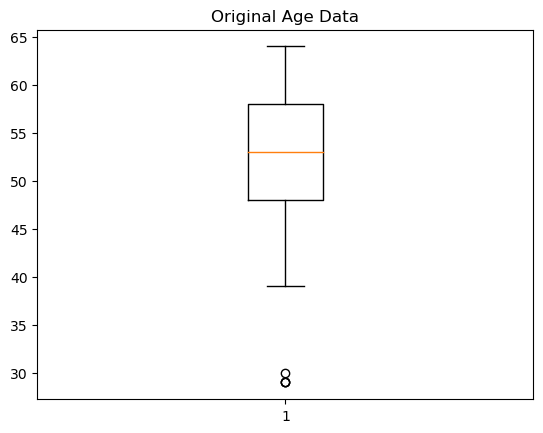

In [910]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Age Data')
ax1.boxplot(df['age'])

{'whiskers': [<matplotlib.lines.Line2D at 0x17cf0ef50>,
 'caps': [<matplotlib.lines.Line2D at 0x16c728820>,
 'boxes': [<matplotlib.lines.Line2D at 0x17cf0c070>],
 'medians': [<matplotlib.lines.Line2D at 0x17ceba9e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17cebbb50>],
 'means': []}

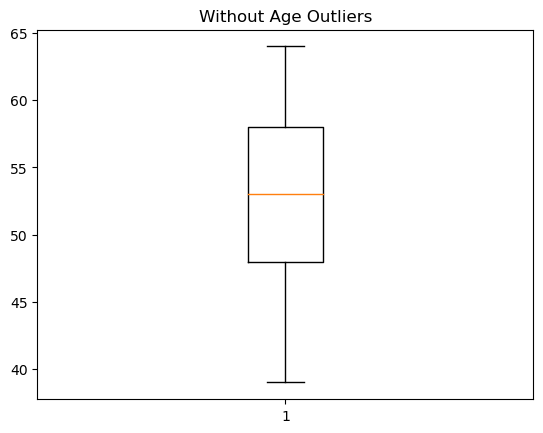

In [911]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Age Outliers')
ax1.boxplot(df_without_outliers['age'])

In [912]:
df_without_outliers = df[(df['age'] > lower_bound) & (df['age'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the height column

In [913]:
df['height'].describe() # uncertain of if this is needed, people have varied height doesnt mean it contributes to CVD. however the column continuous. do correlation matrix to see the relevance

count    69996.000000
mean       164.359063
std          8.210122
min         55.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        250.000000
Name: height, dtype: float64

In [914]:
Q1 = df['height'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['height'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  159.0
Q3  170.0
IQR 11.0


In [915]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  186.5
lower  142.5


In [916]:
df_without_outliers = df[(df['height'] < upper_bound) & (df['height'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69991,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69992,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69993,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69994,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x16c6fcc10>,
 'caps': [<matplotlib.lines.Line2D at 0x16c6ff8e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x17ced9cc0>],
 'medians': [<matplotlib.lines.Line2D at 0x16c6ffa90>],
 'fliers': [<matplotlib.lines.Line2D at 0x17d3a0250>],
 'means': []}

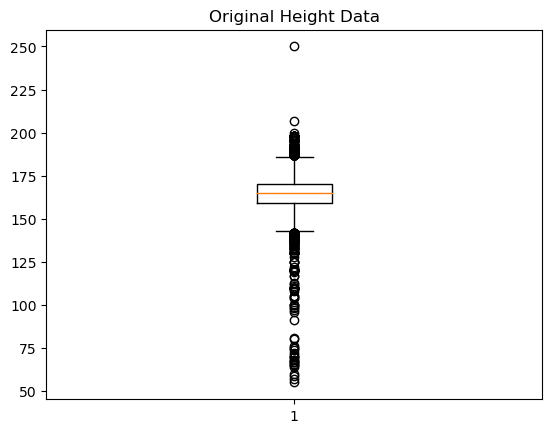

In [917]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Height Data')
ax1.boxplot(df['height'])

{'whiskers': [<matplotlib.lines.Line2D at 0x177dd5b70>,
 'caps': [<matplotlib.lines.Line2D at 0x177dd7af0>,
 'boxes': [<matplotlib.lines.Line2D at 0x177dd4f40>],
 'medians': [<matplotlib.lines.Line2D at 0x177dd5ff0>],
 'fliers': [<matplotlib.lines.Line2D at 0x177dd6b60>],
 'means': []}

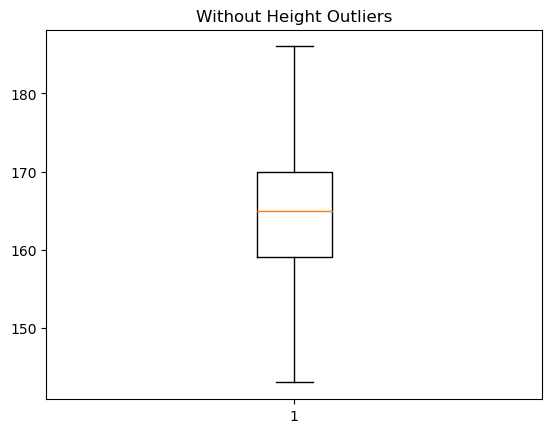

In [918]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Height Outliers')
ax1.boxplot(df_without_outliers['height'])

In [919]:
df_without_outliers = df[(df['height'] > lower_bound) & (df['height'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69473,99995,61,1,158,126.0,140,90,2,2,0,0,1,1
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the weight column

In [920]:
df['weight'].describe()

count    69477.000000
mean        74.152953
std         14.287850
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

In [921]:
Q1 = df['weight'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['weight'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  65.0
Q3  82.0
IQR 17.0


In [922]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  107.5
lower  39.5


In [923]:
df_without_outliers = df[(df['weight'] < upper_bound) & (df['weight'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69471,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
69472,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
69474,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
69475,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x28d9edb70>,
 'caps': [<matplotlib.lines.Line2D at 0x28d9ec640>,
 'boxes': [<matplotlib.lines.Line2D at 0x17674d120>],
 'medians': [<matplotlib.lines.Line2D at 0x28d9ed6f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x28d9ec1f0>],
 'means': []}

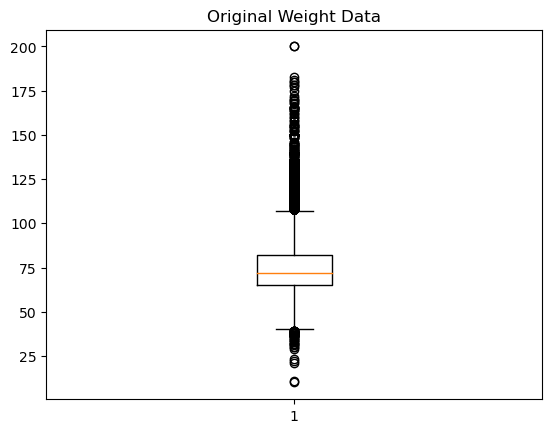

In [924]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Weight Data')
ax1.boxplot(df['weight'])

{'whiskers': [<matplotlib.lines.Line2D at 0x28a1e2710>,
 'caps': [<matplotlib.lines.Line2D at 0x28a1e2c50>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a1e2470>],
 'medians': [<matplotlib.lines.Line2D at 0x28a1e3190>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a1e3430>],
 'means': []}

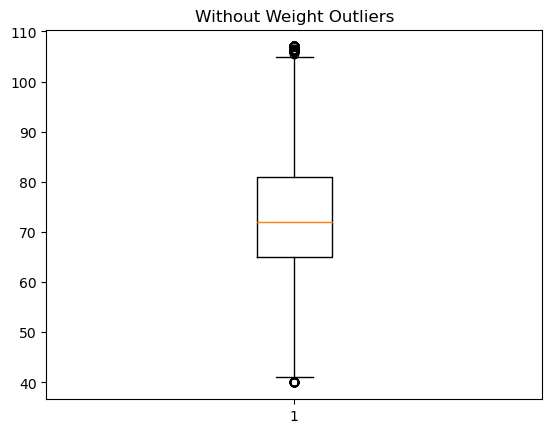

In [925]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Weight Outliers')
ax1.boxplot(df_without_outliers['weight'])

In [926]:
df_without_outliers = df[(df['weight'] > lower_bound) & (df['weight'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67716,99996,52,2,183,105.0,180,90,3,1,0,1,0,1
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_hi column

In [927]:
df['ap_hi'].describe()

count    67719.000000
mean       128.585951
std        156.528328
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

In [928]:
Q1 = df['ap_hi'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_hi'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  120.0
Q3  140.0
IQR 20.0


In [929]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  170.0
lower  90.0


In [930]:
df_without_outliers = df[(df['ap_hi'] < upper_bound) & (df['ap_hi'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67713,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
67714,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
67715,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
67717,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x17fe9ab30>,
 'caps': [<matplotlib.lines.Line2D at 0x28a245420>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a1e3e20>],
 'medians': [<matplotlib.lines.Line2D at 0x28a245960>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a245c00>],
 'means': []}

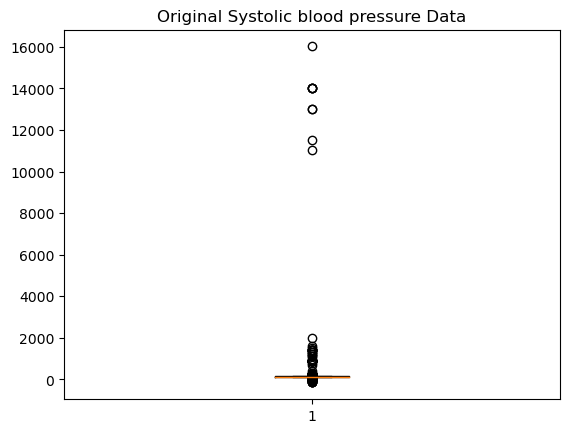

In [931]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Systolic blood pressure Data')
ax1.boxplot(df['ap_hi'])

{'whiskers': [<matplotlib.lines.Line2D at 0x28a287fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x28a2ac550>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a287d90>],
 'medians': [<matplotlib.lines.Line2D at 0x28a2aca90>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a2acd30>],
 'means': []}

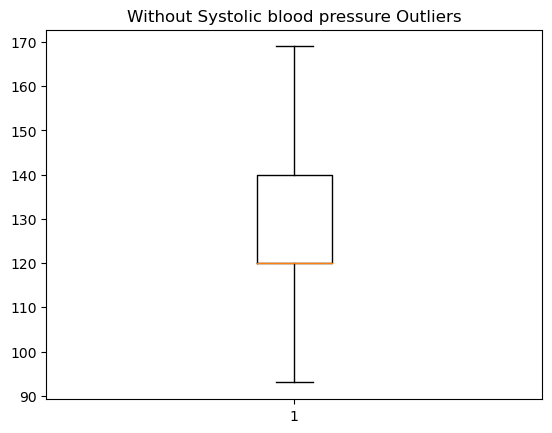

In [932]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Systolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_hi'])

In [933]:
df_without_outliers = df[(df['ap_hi'] > lower_bound) & (df['ap_hi'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


Performing outlier detection on the ap_lo column

In [934]:
df['ap_lo'].describe()

count    64803.000000
mean        93.685107
std        181.503375
min          0.000000
25%         80.000000
50%         80.000000
75%         90.000000
max      10000.000000
Name: ap_lo, dtype: float64

In [935]:
Q1 = df['ap_lo'].quantile(0.25)
print("Q1 ", Q1)
Q3 = df['ap_lo'].quantile(0.75)
print("Q3 ", Q3)
IQR = Q3 - Q1
print("IQR", IQR)

Q1  80.0
Q3  90.0
IQR 10.0


In [936]:
upper_bound = Q3 + 1.5 * IQR
print("upper ", upper_bound)
lower_bound = Q1 - 1.5 * IQR
print("lower ", lower_bound)

upper  105.0
lower  65.0


In [937]:
df_without_outliers = df[(df['ap_lo'] < upper_bound) & (df['ap_lo'] > lower_bound)]
df_without_outliers

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
5,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64798,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
64799,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
64800,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
64801,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


{'whiskers': [<matplotlib.lines.Line2D at 0x28a306b00>,
 'caps': [<matplotlib.lines.Line2D at 0x28a307040>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a306860>],
 'medians': [<matplotlib.lines.Line2D at 0x28a307580>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a307820>],
 'means': []}

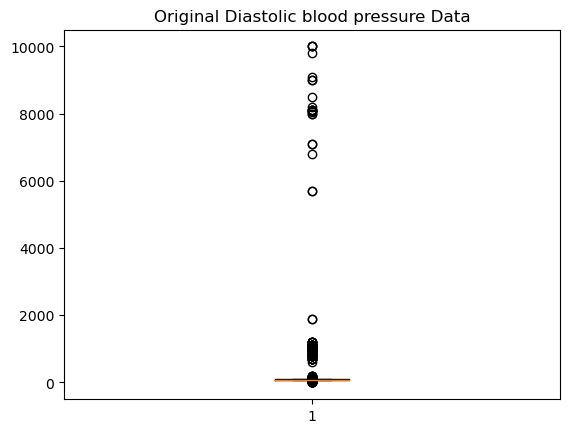

In [938]:
fig1, ax1 = plt.subplots()
ax1.set_title('Original Diastolic blood pressure Data')
ax1.boxplot(df['ap_lo'])

{'whiskers': [<matplotlib.lines.Line2D at 0x28a38c6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x28a38cbe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x28a2aff70>],
 'medians': [<matplotlib.lines.Line2D at 0x28a38d000>],
 'fliers': [<matplotlib.lines.Line2D at 0x28a38d2a0>],
 'means': []}

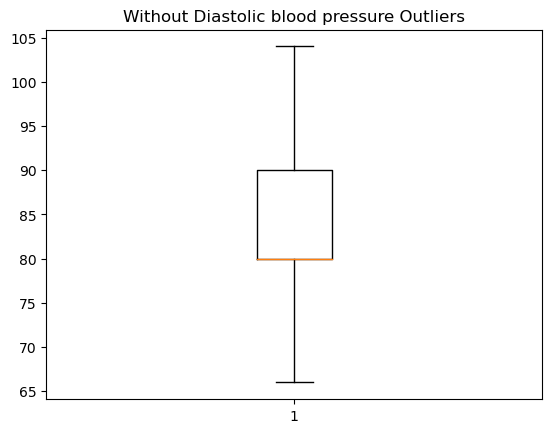

In [939]:
fig1, ax1 = plt.subplots()
ax1.set_title('Without Diastolic blood pressure Outliers')
ax1.boxplot(df_without_outliers['ap_lo'])

In [940]:
df_without_outliers = df[(df['ap_lo'] > lower_bound) & (df['ap_lo'] < upper_bound)].reset_index(drop=True)
df = df_without_outliers
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,8,59,1,151,67.0,120,80,2,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,99991,53,1,172,70.0,130,90,1,1,0,0,1,1
61767,99992,57,1,165,80.0,150,80,1,1,0,0,1,1
61768,99993,52,2,168,76.0,120,80,1,1,1,0,1,0
61769,99998,61,1,163,72.0,135,80,1,2,0,0,0,1


## EDA

Non-Modifiable Cause:

Old Age
Heridity
Gender Factor such as Male

Modifiable Cause: 
Alcohol
Smoking
Physical activity


## Univariate and Bivariate analysis 


In [941]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [942]:
# to understand variables look at their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61771 entries, 0 to 61770
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           61771 non-null  int64  
 1   age          61771 non-null  int64  
 2   gender       61771 non-null  int64  
 3   height       61771 non-null  int64  
 4   weight       61771 non-null  float64
 5   ap_hi        61771 non-null  int64  
 6   ap_lo        61771 non-null  int64  
 7   cholesterol  61771 non-null  int64  
 8   gluc         61771 non-null  int64  
 9   smoke        61771 non-null  int64  
 10  alco         61771 non-null  int64  
 11  active       61771 non-null  int64  
 12  cardio       61771 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.1 MB


#### Investigating if age has an influence on the target variable 

<AxesSubplot: xlabel='age', ylabel='count'>

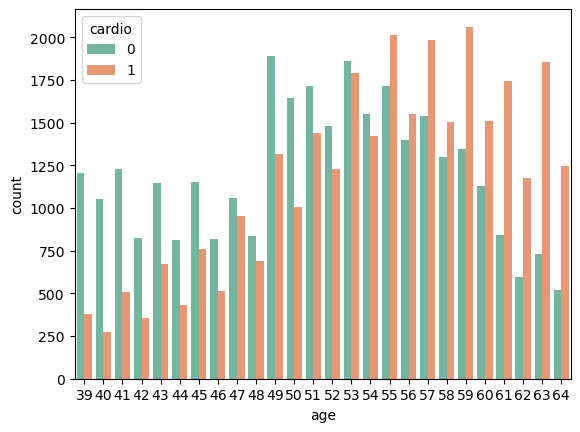

In [943]:
sns.countplot(x='age', hue='cardio', data = df, palette="Set2")
#This plot has shown that CVD is more prevalent in patients who 55 years old and  older hence age influences the target variable- presence or absence of CVD

#### Descriptive statistics

In [944]:
df.describe()
#displays statistics such as min, max, mean, std

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000,61771.000000
mean,49958.487041,52.863123,1.348853,164.421622,73.159013,126.182189,81.651163,1.355863,1.220103,0.086432,0.052015,0.804309,0.491865
std,28868.135268,6.734729,0.476611,7.526360,12.247023,13.692640,7.566325,0.674082,0.567387,0.281003,0.222058,0.396735,0.499938
min,0.000000,39.000000,1.000000,143.000000,40.000000,95.000000,66.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24888.500000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50013.000000,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74893.500000,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,64.000000,2.000000,186.000000,107.000000,169.000000,104.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Investigation the gender distribution in the dataset

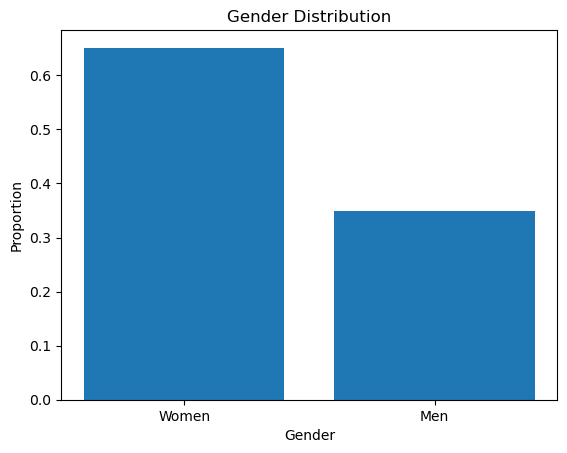

In [945]:
gender_map = {1: 'Women', 2: 'Men'}
gender_counts = df['gender'].map(gender_map).value_counts(normalize=True)
plt.bar(gender_counts.index, gender_counts)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Proportion')
plt.show()
# there are more female test subjects in the dataset than male

#### Investigating if gender has an influence on the target variable 

<AxesSubplot: xlabel='gender', ylabel='count'>

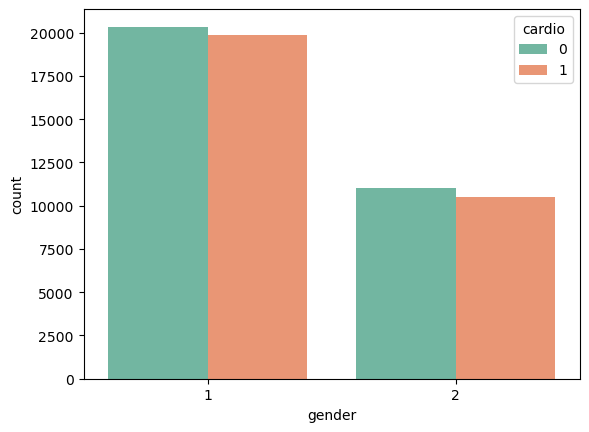

In [946]:
sns.countplot(x='gender', hue='cardio', data = df, palette="Set2")
#gender does not affect the target variable

<AxesSubplot: xlabel='variable', ylabel='count'>

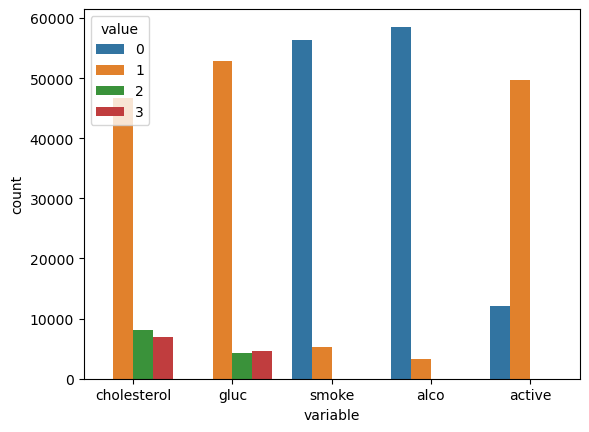

In [947]:
df_categorical = df.loc[:,['cholesterol','gluc', 'smoke', 'alco', 'active']]
sns.countplot(x="variable", hue="value",data= pd.melt(df_categorical))
# this shows the socioeconomic factors that affect patients (some attributes that may lead to cvd)

<AxesSubplot: ylabel='Frequency'>

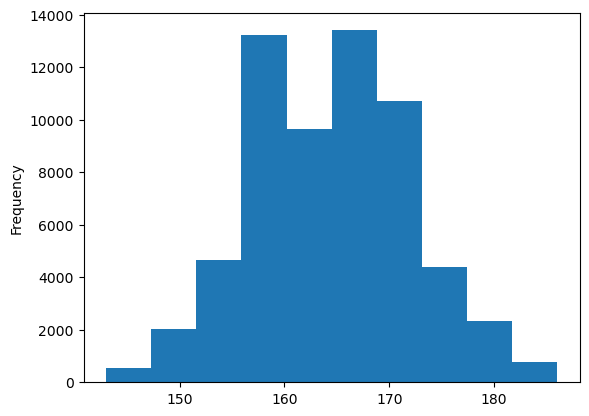

In [948]:
df['height'].plot(kind='hist')
# patients in this dataset were avg 150-175 in height

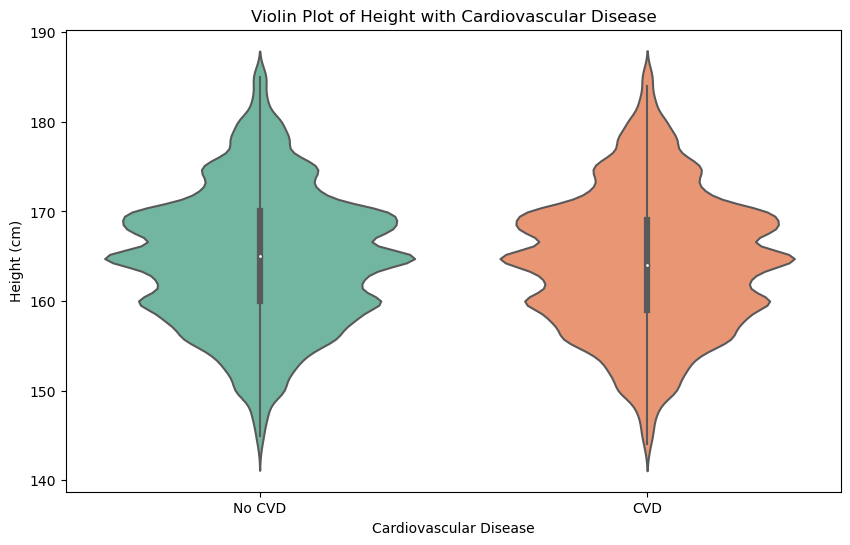

In [949]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='cardio', y='height', data=df, palette='Set2')
plt.xticks(ticks=[0, 1], labels=['No CVD', 'CVD'])
plt.title('Violin Plot of Height with Cardiovascular Disease')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('Height (cm)')
plt.show()
#height has no significant influence on target variable

<AxesSubplot: ylabel='Frequency'>

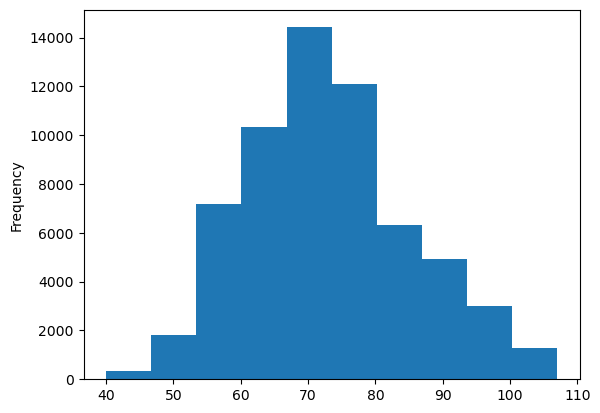

In [950]:
df['weight'].plot(kind='hist')
#patients in this dataset (were mainly 50-80 in weight)

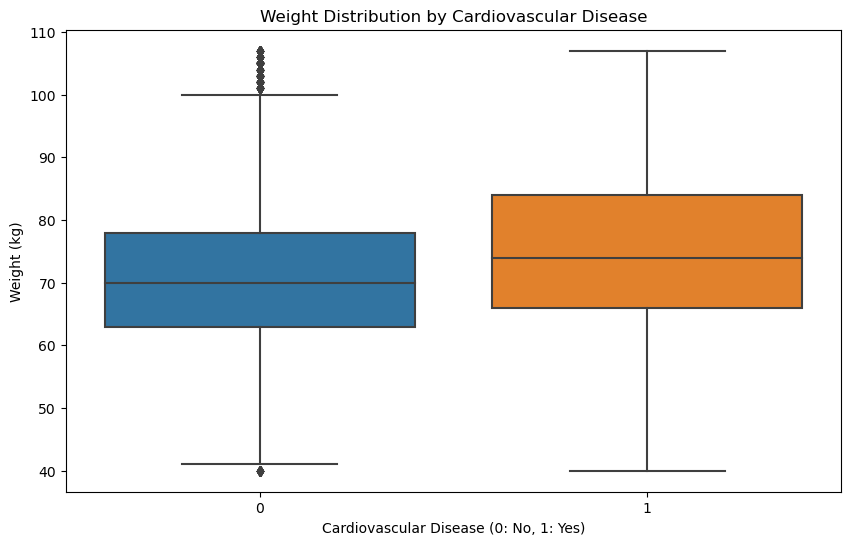

In [951]:
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='cardio', y='weight', data=df)
plt.title('Weight Distribution by Cardiovascular Disease')
plt.xlabel('Cardiovascular Disease (0: No, 1: Yes)')
plt.ylabel('Weight (kg)')
plt.show()
#weight has no significant influence on target variable

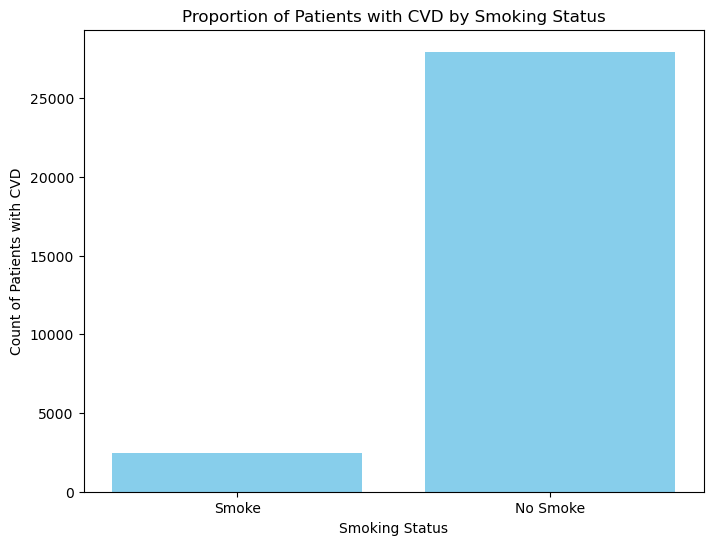

In [952]:
smoke_cvd_counts = df[df['smoke'] == 1]['cardio'].value_counts()
no_smoke_cvd_counts = df[df['smoke'] == 0]['cardio'].value_counts()
plt.figure(figsize=(8, 6)) 
plt.bar(['Smoke', 'No Smoke'], [smoke_cvd_counts[1], no_smoke_cvd_counts[1]], color='skyblue')
plt.title('Proportion of Patients with CVD by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count of Patients with CVD')
plt.show()
#the majority of the test subjects with cardio were none smokers

In [953]:
df['smoke'].value_counts()
# based on the dataset, the majority of patients are none smokers hence find the percentage of cvd test subjects in each class

0    56432
1     5339
Name: smoke, dtype: int64

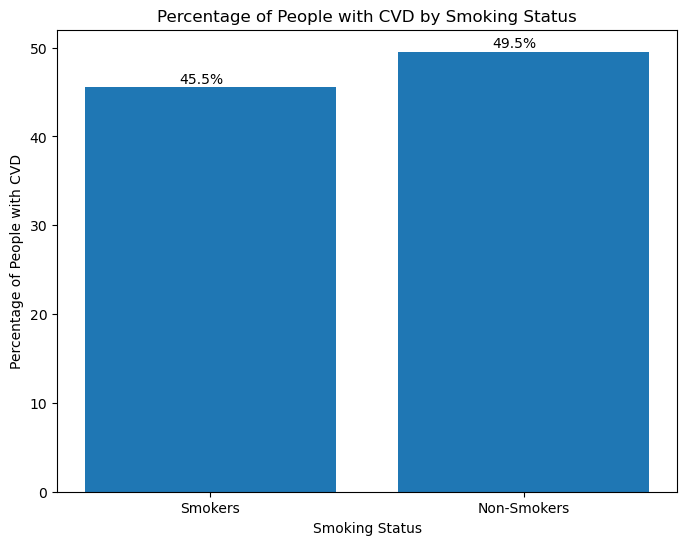

In [954]:
smokers_with_cvd = df[df['smoke'] == 1]['cardio'].mean() * 100
non_smokers_with_cvd = df[df['smoke'] == 0]['cardio'].mean() * 100
plt.figure(figsize=(8, 6))
plt.bar(['Smokers', 'Non-Smokers'], [smokers_with_cvd, non_smokers_with_cvd])
plt.title('Percentage of People with CVD by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage of People with CVD')
plt.text(-0.1, smokers_with_cvd + 0.5, f'{smokers_with_cvd:.1f}%', color='black')
plt.text(0.9, non_smokers_with_cvd + 0.5, f'{non_smokers_with_cvd:.1f}%', color='black')
plt.show()
#This indicates that smoking may not be the sole risk factor for CVD 

<AxesSubplot: ylabel='alco'>

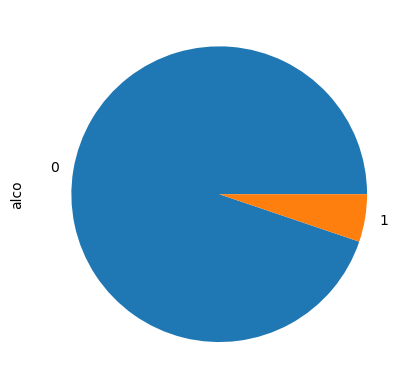

In [955]:
df["alco"].value_counts().plot(kind='pie')
# most of the patients in the dataset are seen to be non alcoholics  

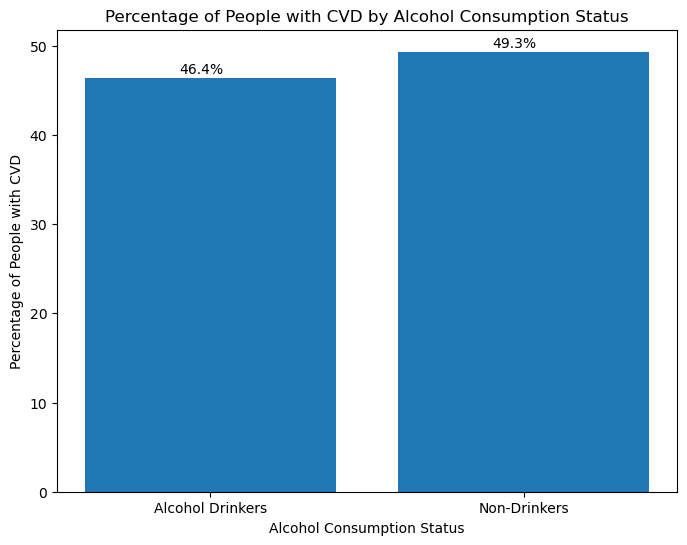

In [956]:
drinkers_with_cvd = df[df['alco'] == 1]['cardio'].mean() * 100
non_drinkers_with_cvd = df[df['alco'] == 0]['cardio'].mean() * 100
plt.figure(figsize=(8, 6))
plt.bar(['Alcohol Drinkers', 'Non-Drinkers'], [drinkers_with_cvd, non_drinkers_with_cvd])
plt.title('Percentage of People with CVD by Alcohol Consumption Status')
plt.xlabel('Alcohol Consumption Status')
plt.ylabel('Percentage of People with CVD')
plt.text(-0.1, drinkers_with_cvd + 0.5, f'{drinkers_with_cvd:.1f}%', color='black')
plt.text(0.9, non_drinkers_with_cvd + 0.5, f'{non_drinkers_with_cvd:.1f}%', color='black')
plt.show()
#Alcoholism has no significant influence on target variable in the dataset

<AxesSubplot: ylabel='active'>

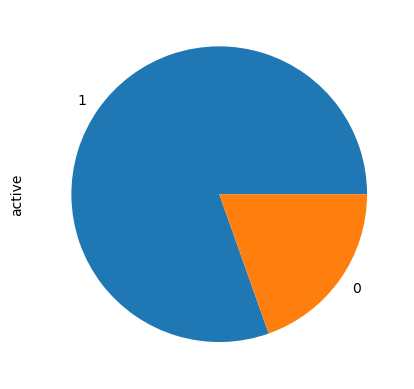

In [957]:
df["active"].value_counts().plot(kind='pie')
#most of the patients in the dataset are seen to be more physically active than inactive

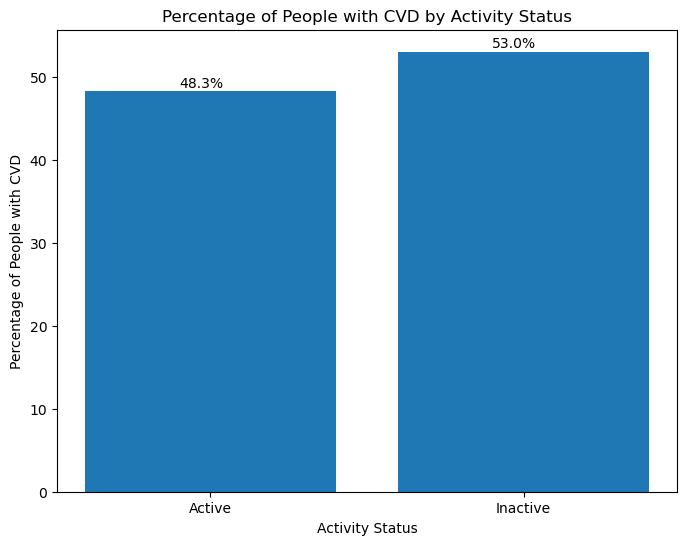

In [958]:
active_with_cvd = df[df['active'] == 1]['cardio'].mean() * 100
inactive_with_cvd = df[df['active'] == 0]['cardio'].mean() * 100
plt.figure(figsize=(8, 6))
plt.bar(['Active', 'Inactive'], [active_with_cvd, inactive_with_cvd])
plt.title('Percentage of People with CVD by Activity Status')
plt.xlabel('Activity Status')
plt.ylabel('Percentage of People with CVD')
plt.text(-0.1, active_with_cvd + 0.5, f'{active_with_cvd:.1f}%', color='black')
plt.text(0.9, inactive_with_cvd + 0.5, f'{inactive_with_cvd:.1f}%', color='black')
plt.show()
#activity has no significant influence on target variable in the dataset through there are more patients with cvd are that physically inactive 

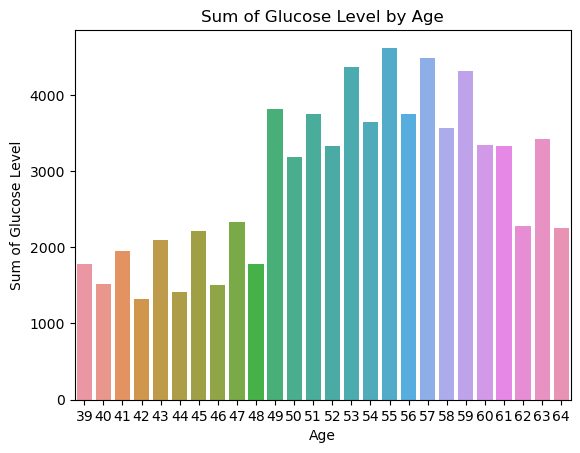

In [959]:
gluc_sum_by_gender = df.groupby('age')['gluc'].sum()
sns.barplot(x=gluc_sum_by_gender.index, y=gluc_sum_by_gender.values)
plt.title('Sum of Glucose Level by Age')
plt.xlabel('Age')
plt.ylabel('Sum of Glucose Level')
plt.show()
# ages 49-59 seems to have the highest glucose level

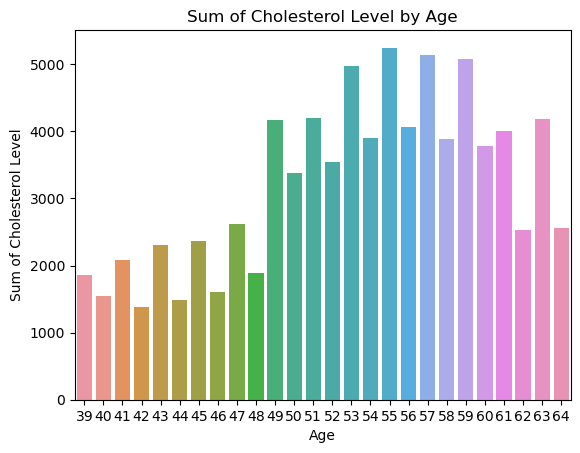

In [960]:
cholesterol_sum_by_age = df.groupby('age')['cholesterol'].sum()
sns.barplot(x=cholesterol_sum_by_age.index, y=cholesterol_sum_by_age.values)
plt.title('Sum of Cholesterol Level by Age')
plt.xlabel('Age')
plt.ylabel('Sum of Cholesterol Level')
plt.show()
# ages 49-59 seems to have the highest cholesterol level

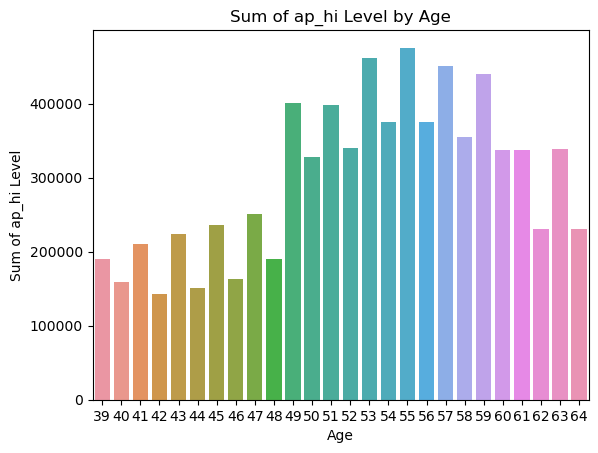

In [961]:
ap_hi_sum_by_age = df.groupby('age')['ap_hi'].sum()
sns.barplot(x=ap_hi_sum_by_age.index, y=ap_hi_sum_by_age.values)
plt.title('Sum of ap_hi Level by Age')
plt.xlabel('Age')
plt.ylabel('Sum of ap_hi Level')
plt.show()
# ages 49-59 seems to have the highest ap_hi

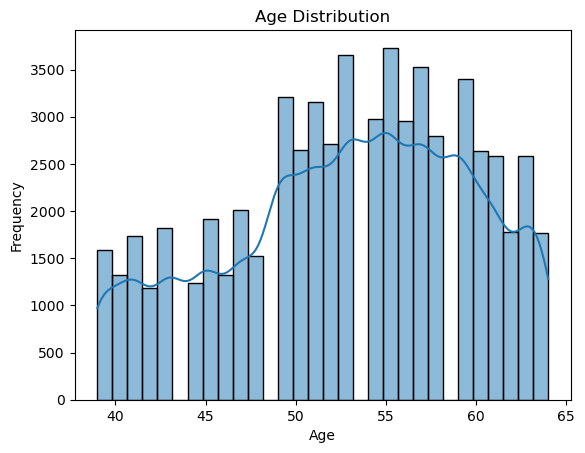

In [962]:
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()
#majority of test subject are within the 49-59 age group hence the major influence in the plot above

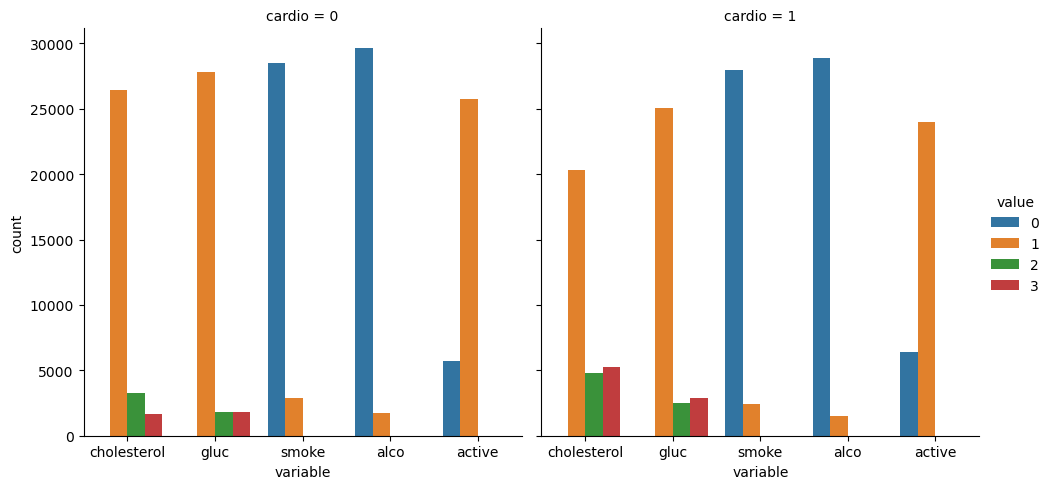

In [963]:
data1 = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value",col="cardio",data= data1,kind="count")
# this shows that patients who have high cholesterol and high glucose level are more prone to have CVD

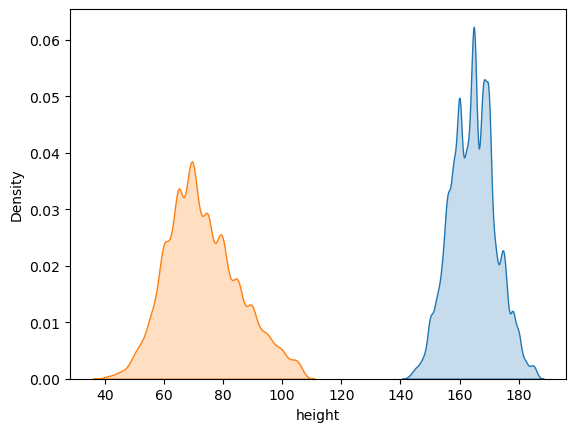

In [964]:
for col in ["height", "weight"]:
    sns.kdeplot(df[col], shade=True)

Calculating the BMI

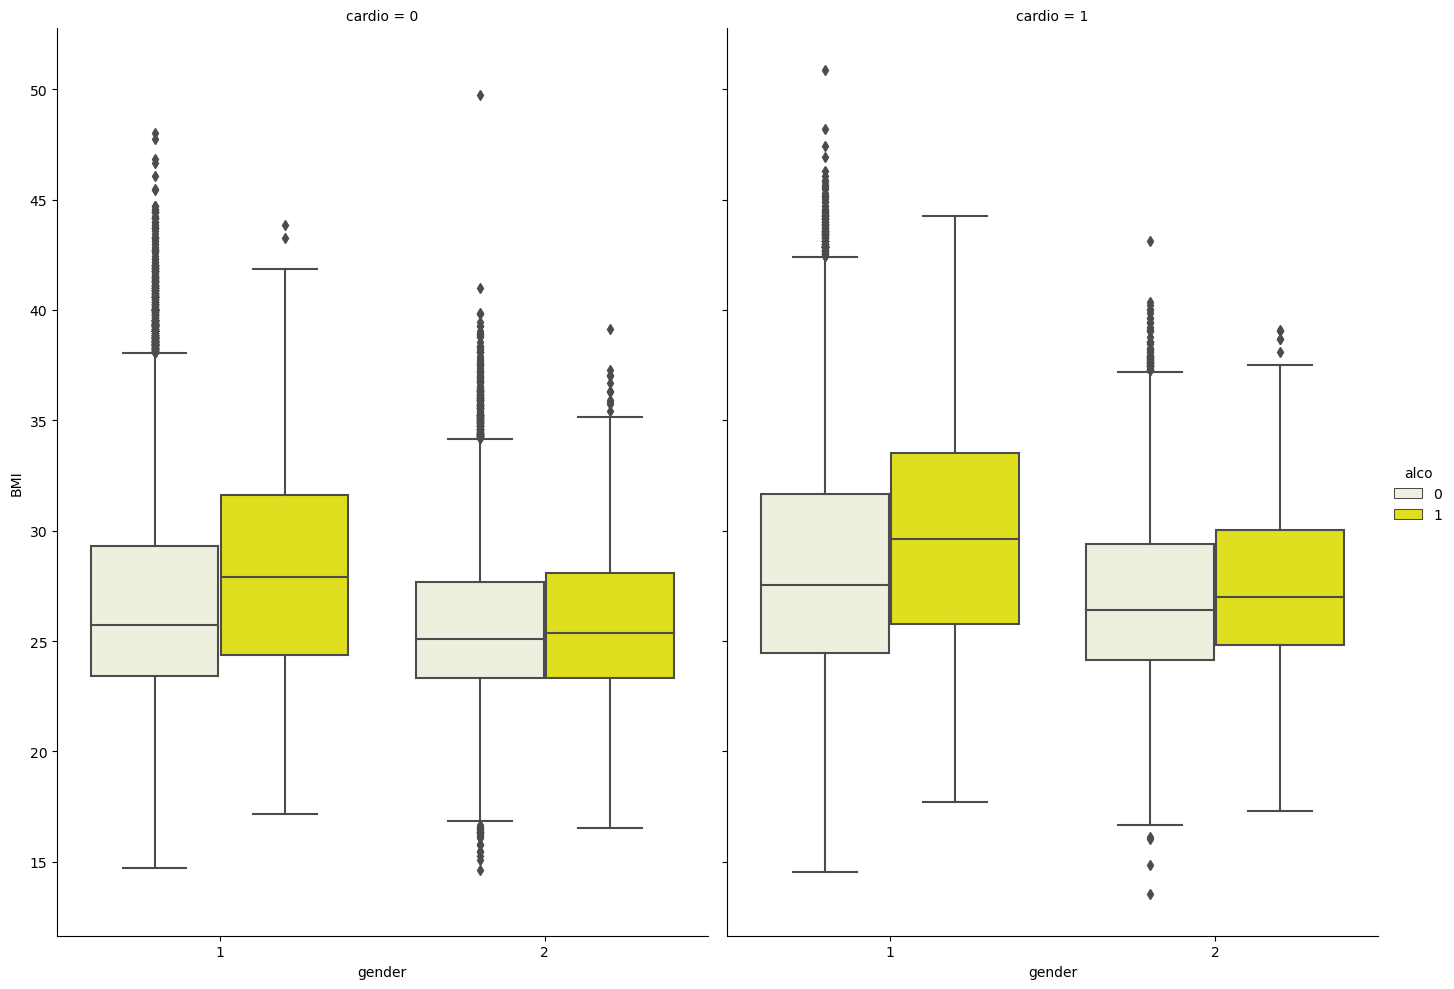

In [965]:
df['BMI'] = df['weight']/((df['height']/100)**2)
sns.catplot(x="gender", y="BMI", hue="alco", col="cardio", data=df, color = "yellow",kind="box", height=10, aspect=.7)

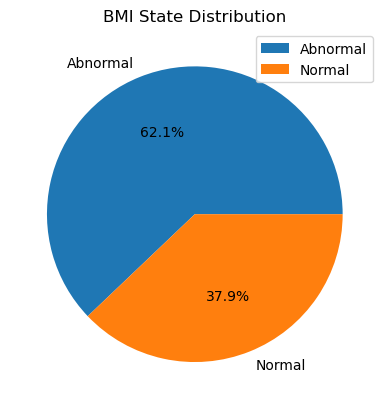

In [966]:
# determining normal & abnormal BMI
def bmi(bmi_num):
  if 18.5 <= bmi_num <= 25:
    return "Normal"
  else:
    return "Abnormal"

df["BMI_State"] = df["BMI"].apply(lambda x: bmi(x))
value_counts = df['BMI_State'].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
plt.title('BMI State Distribution')
plt.legend(value_counts.index)
plt.show()
#There was a higher rate of abnormal BMI than normal

In [967]:
df
df = df.drop('BMI', axis=1)
#drop bmi col since its converted to bmi state

In [968]:
bmi_state_mapping = {'Normal': 0, 'Abnormal': 1}
df['BMI_State'] = df['BMI_State'].map(bmi_state_mapping)
df['BMI_State'] = df['BMI_State'].astype(int)
df

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI_State
0,0,50,2,168,62.0,110,80,1,1,0,0,1,0,0
1,1,55,1,156,85.0,140,90,3,1,0,0,1,1,1
2,2,51,1,165,64.0,130,70,3,1,0,0,0,1,0
3,3,48,2,169,82.0,150,100,1,1,0,0,1,1,1
4,8,59,1,151,67.0,120,80,2,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61766,99991,53,1,172,70.0,130,90,1,1,0,0,1,1,0
61767,99992,57,1,165,80.0,150,80,1,1,0,0,1,1,1
61768,99993,52,2,168,76.0,120,80,1,1,1,0,1,0,1
61769,99998,61,1,163,72.0,135,80,1,2,0,0,0,1,1


<AxesSubplot: xlabel='BMI_State', ylabel='count'>

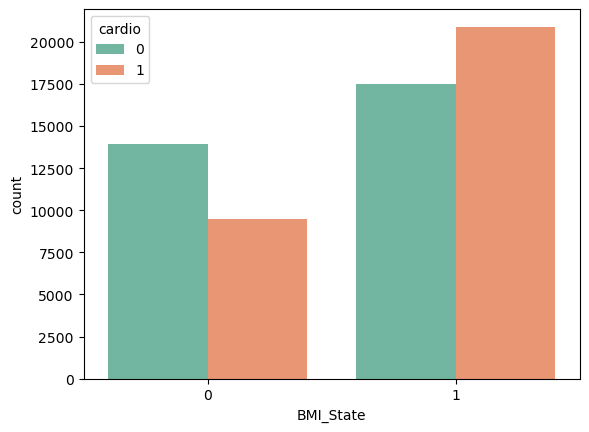

In [969]:
sns.countplot(x='BMI_State', hue='cardio', data = df, palette="Set2")
##patients with abnormal BMI are more prone to CVD

## Multivariate

Using correlation matrix to identify the features that are most strongly associated with the target variable.

/var/folders/lg/3khrfgwn2w920qd0wcmjxpph0000gn/T/ipykernel_83589/1352989231.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_matrix, dtype=np.bool)
/var/folders/lg/3khrfgwn2w920qd0wcmjxpph0000gn/T/ipykernel_83589/1352989231.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  create = np.zeros_like(corr_matrix, dtype=np.

<AxesSubplot: >

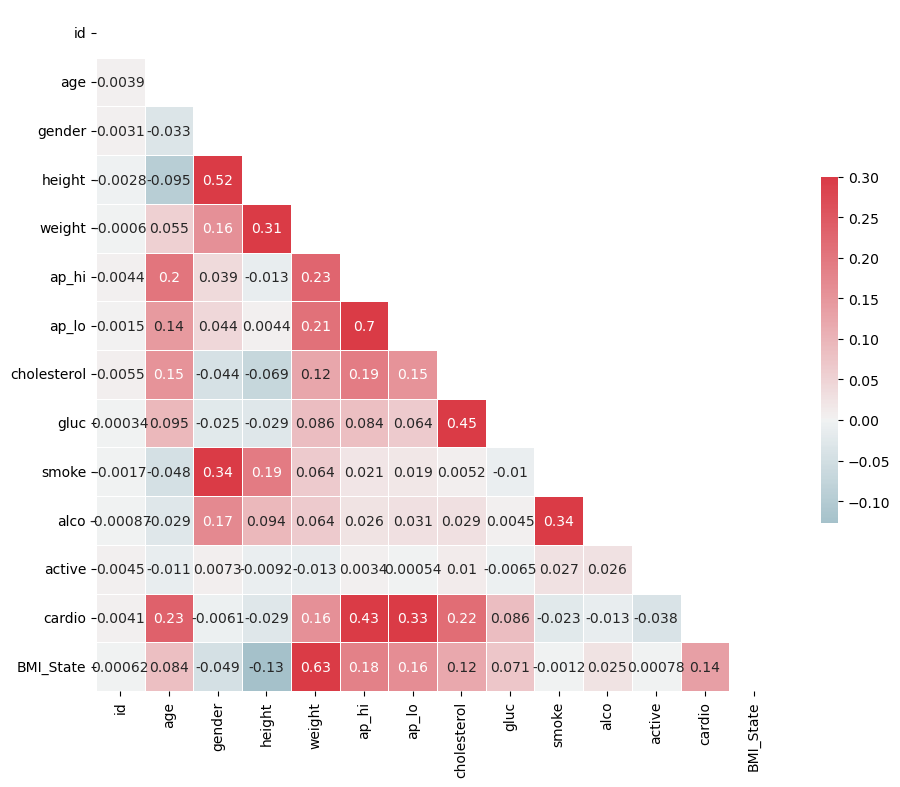

In [970]:
# Compute the correlation matrix
corr_matrix = df.corr()
# create a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
create = np.zeros_like(corr_matrix, dtype=np.bool)
create[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The correlation matrix revealed that age, weight, BMI_State, cholesterol, systolic blood pressure, and diastolic blood pressure had a high positive correlation with the presence or absence of CVD. 


<AxesSubplot: >

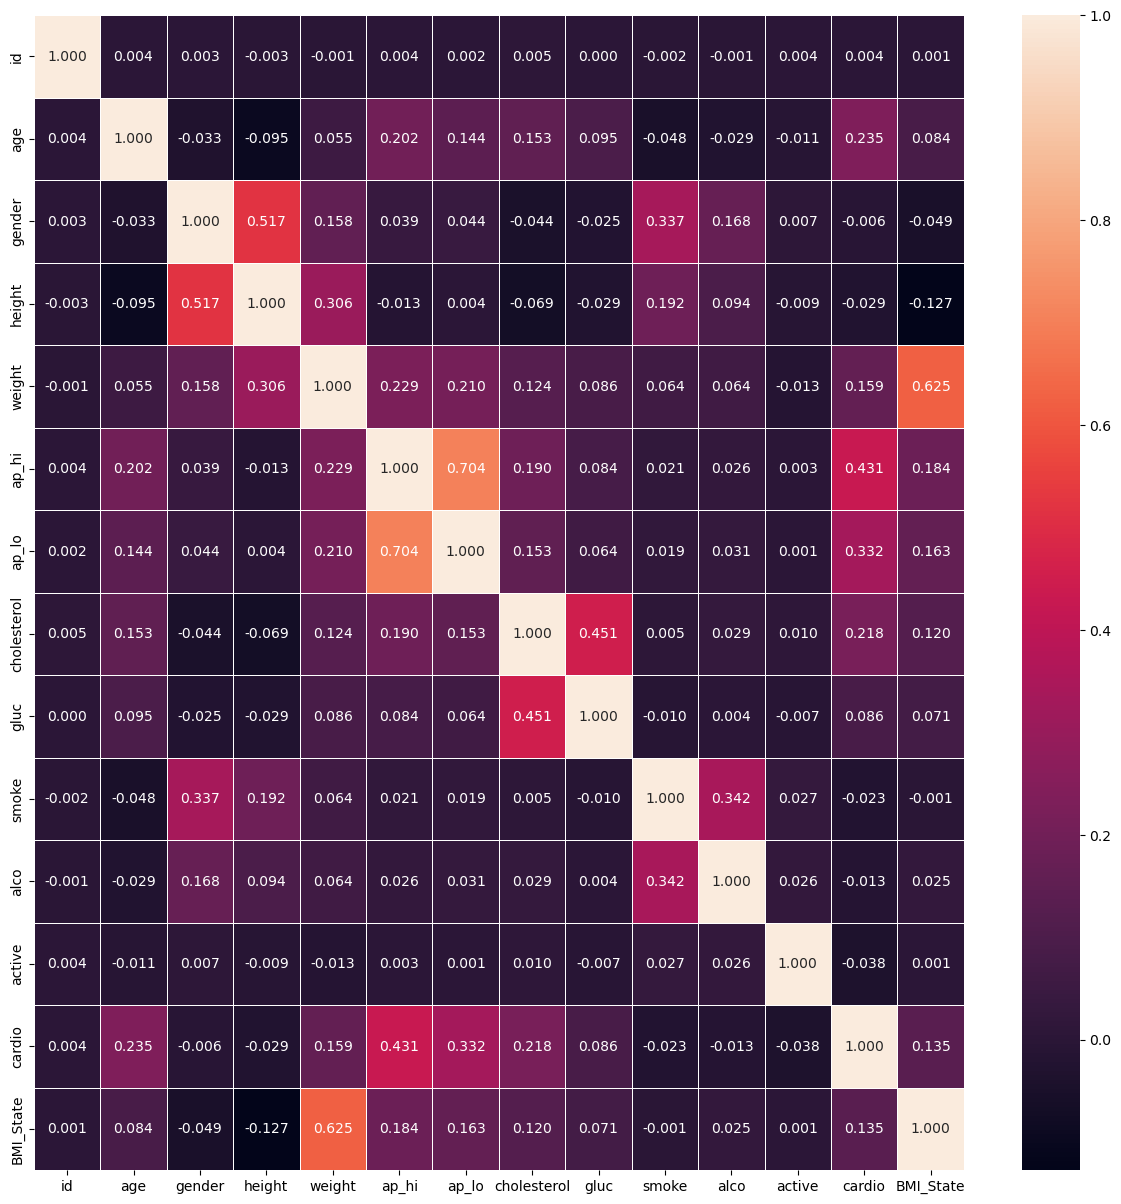

In [971]:
corr = df.corr()
f, ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr, annot=True, fmt=".3f", linewidths=0.5, ax=ax)

From the heatmap, the weight, BMI_State, age, systolic blood pressure, and diastolic blood pressure and cholestrol seem to have the highest correlation with respect to our target variable(cardio). There is a correlation between weight, age and cholesterol?. Being overweight or obese tends to increase bad cholesterol and lower good cholesterol. Aging also causes cholesterol to increase. 

Cholesterol and glucose have a high correlation, whcih makes sense due to studies which show that elevated blood glucose levels (any type of diabetes) poses a risk of higher cholesterol, manifesting as diabetic dyslipidemia.

### Feature Selection


K-best selector using the SelectKBest class with a mutual_info_classif as the scoring function since its suitable for both continuous and categorical features.


In [972]:
X = df.drop("cardio", axis=1)
y = df["cardio"]
k = 6
# SelectKBest object with mutual_info_classif as the scoring function
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_indices = selector.get_support(indices=True)
selected_features = [X.columns[i] for i in selected_indices]
X_selected = selector.transform(X)
print("Selected features:", selected_features)

Selected features: ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI_State']


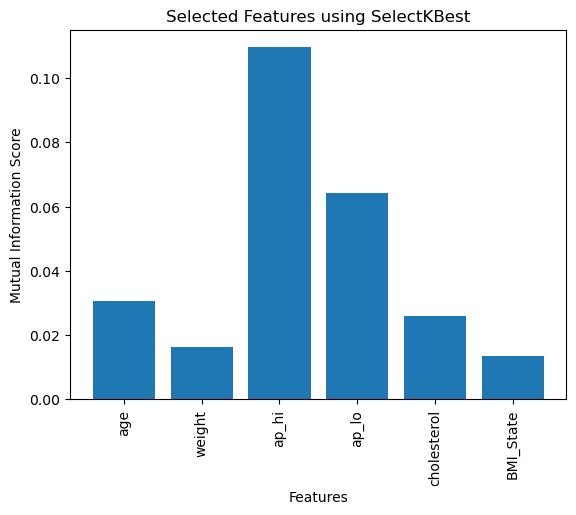

In [973]:
plt.bar(range(len(selected_features)), selector.scores_[selected_indices])
plt.xticks(range(len(selected_features)), selected_features, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.title('Selected Features using SelectKBest')
plt.show()

The results of the K-best selector confirmed that age, weight, systolic and diastolic blood pressure, cholesterol and BMI_State were highly correlated features that had a significant impact on the presence or absence of CVD. This is consistent with the findings from the correlation matrix, which also identified these features as being strongly associated. 

### Checking linearity of the dataset

In [974]:
polynomial_features = PolynomialFeatures(degree=2) 
X_poly = polynomial_features.fit_transform(X)
model = LinearRegression()
model.fit(X_poly, y)
r2 = model.score(X_poly, y)
print(f'R-squared: {r2}')


R-squared: 0.24648303262251836


the linear relationship features and the target variable is relatively weak, there may be other factors or nonlinear relationships that are not captured by the linear regression model. 

#### Binary Classification: Random Forest

In [975]:
# Split the dataset into a 70-20-10 ratio for training, testing, and prediction sets, respectively.
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), df['cardio'], test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

Experiment training the model with default hyperparameters

In [976]:
# Train model
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# Make predictions 
y_pred = rf_clf.predict(X_test)

# check performance score
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))

Accuracy 0.7174613402061856
Recall 0.6961859551481421
f1 score 0.7080073247877475
precision 0.7202370872142252


Experiemnet undersampling

In [977]:
X = df.drop('cardio', axis=1)
y = df['cardio']

# RandomUnderSampler
rus = RandomUnderSampler()
# undersample data
X_resampled, y_resampled = rus.fit_resample(X, y)
print(y_resampled.value_counts())

0    30383
1    30383
Name: cardio, dtype: int64


In [978]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [979]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))

Accuracy 0.7105780252169641
Recall 0.6859958003553546
f1 score 0.7061268600881204
precision 0.7274751627269613


Experiemnt  over sampling

In [980]:
X = df.drop('cardio', axis=1)
y = df['cardio']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())
print(X_resampled.value_counts())

0    31388
1    31388
Name: cardio, dtype: int64
id     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  BMI_State
0      50   2       168     62.0    110    80     1            1     0      0     1       0            1
66631  63   2       171     73.0    150    90     1            1     0      0     0       0            1
66633  49   1       163     95.0    125    80     2            1     0      0     1       1            1
66635  47   1       166     83.0    110    70     1            1     0      0     1       1            1
66636  63   2       171     69.0    130    80     2            1     0      0     1       0            1
                                                                                                      ..
33305  58   1       162     77.0    130    80     2            1     0      0     0       1            1
33309  53   1       160     80.0    130    80     3            1     0      0     1       1            1
33310  61  

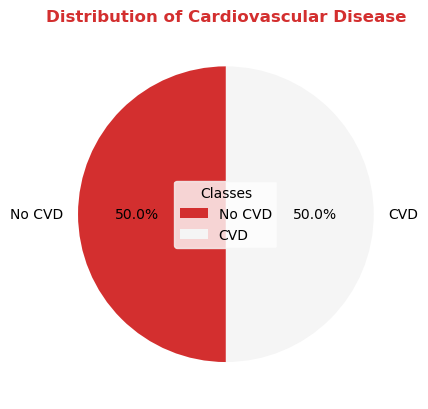

In [981]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  
y_resampled_df = pd.DataFrame(y_resampled, columns=[y.name])  
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)
counts = df_resampled['cardio'].value_counts()
colors = ['#D32F2F', '#F5F5F5']
fig, ax = plt.subplots()
ax.pie(counts, labels=['No CVD', 'CVD'], colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_facecolor('#F5F5F5')
ax.set_title('Distribution of Cardiovascular Disease', color='#D32F2F', fontweight='bold')
ax.legend(title='Classes', loc='center', edgecolor='#F5F5F5')
plt.show()

In [982]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [983]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy_1_ran = accuracy_score(y_test, y_pred)
recall_1_ran = recall_score(y_test, y_pred)
f1_score_1_ran = f1_score(y_test, y_pred)
precision_1_ran = precision_score(y_test, y_pred)


Accuracy 0.7122364875574576
Recall 0.6932466708941027
f1 score 0.7066332713904824
precision 0.7205470423463503


for teh random forest model the oversampling experiemnt had the highest f1 score , hence it used throughout the experiments

Experiemnt Feature selection using boruta with oversampled dataset

In [984]:
# boruta feature selector
boruta_selector = BorutaPy(rf_clf, n_estimators='auto', verbose=2)
boruta_selector.fit(X_train.values, y_train.values)
selected_features = X_train.columns[boruta_selector.support_].tolist()

# Update test and training set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]   
}

# Grid search
grid_search = GridSearchCV(rf_clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train with the best hyperparameters
best_rf_clf_boruta = RandomForestClassifier(**best_params)
best_rf_clf_boruta.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_clf_boruta.predict(X_test)

# Evaluate the model
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy_2_ran = accuracy_score(y_test, y_pred)
recall_2_ran = recall_score(y_test, y_pred)
f1_score_2_ran = f1_score(y_test, y_pred)
precision_2_ran = precision_score(y_test, y_pred)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	13
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	10
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	2
Rejected: 	10
I

Experiment grid search only

In [985]:
param_grid = {
    'n_estimators': [10, 50, 100],  
    'max_depth': [None, 10, 20], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]   
}

# Grid search
grid_search = GridSearchCV(rf_clf, param_grid, cv=10)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train with the best hyperparameters
best_rf_clf = RandomForestClassifier(**best_params)
best_rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_clf.predict(X_test)

# Evaluate the model
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy_3_ran = accuracy_score(y_test, y_pred)
recall_3_ran = recall_score(y_test, y_pred)
f1_score_3_ran = f1_score(y_test, y_pred)
precision_3_ran = precision_score(y_test, y_pred)


Accuracy 0.7072436202250753
Recall 0.6139822447685479
f1 score 0.6770979020979021
precision 0.754676539360873


Experiment Cross validation and stratification 

In [986]:
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# Cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(best_rf_clf, X_train, y_train, cv=stratified_kfold, scoring=scoring_metrics)
# evaluate
print("Cross-validation results:")
accuracy_4_ran = cv_results['test_accuracy'].mean()
recall_4_ran = cv_results['test_recall'].mean()
precision_4_ran = cv_results['test_precision'].mean()
f1_score_4_ran = cv_results['test_precision'].mean()
print(accuracy_4_ran)
print(recall_4_ran)
print(precision_4_ran)
print(f1_score_4_ran)

Cross-validation results:
0.7036615575402966
0.606375227686703
0.7525845619841853
0.7525845619841853


#### roc curve

To effectively predict the probability of a patient having CVD, we needed to determine an appropriate decision threshold.

To accomplish this, we utilized the receiver operating characteristic (ROC) curve to assess the trade-off between true positive rate (TPR) and false positive rate (FPR) at different decision thresholds. 


Optimal decision threshold: 0.4721534945618536


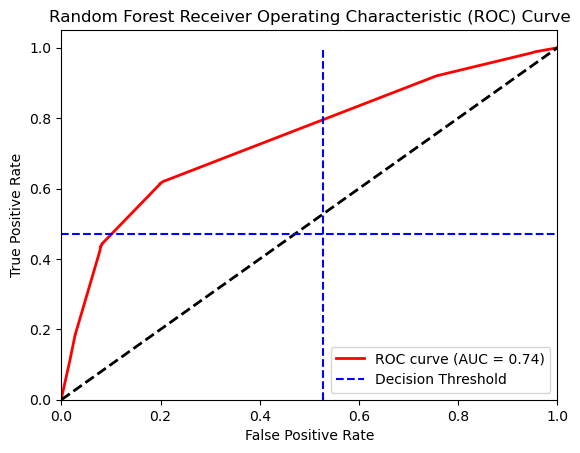

In [987]:
y_prob = best_rf_clf_boruta.predict_proba(X_test)[:, 1]
y_test = y_test

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal decision threshold:", optimal_threshold)
plt.plot([0, 1], [optimal_threshold, optimal_threshold], linestyle='--', color='blue', label='Decision Threshold')
plt.plot([1 - optimal_threshold, 1 - optimal_threshold], [0, 1], linestyle='--', color='blue')
plt.legend(loc="lower right")
plt.show()

Mkaing prediction

In [988]:
y_pred_proba =best_rf_clf.predict_proba(X_test)[:, 1]  
decision_threshold = optimal_threshold
y_pred = (y_pred_proba >= decision_threshold).astype(int)  
print("Predicted probabilities of CVD:\n", y_pred_proba)
print("Predicted binary labels for CVD (0 or 1):\n", y_pred)

Predicted probabilities of CVD:
 [0.24894681 0.24894681 0.36113526 ... 0.60218689 0.36113526 0.861717  ]
Predicted binary labels for CVD (0 or 1):
 [0 0 0 ... 1 0 1]


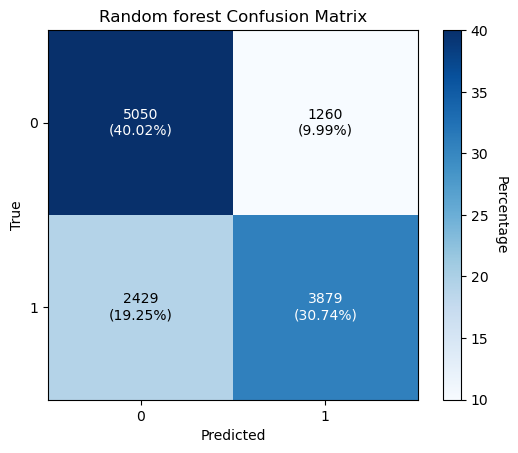

In [989]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / np.sum(cm) * 100
fig, ax = plt.subplots()
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n({cm_percent[i, j]:.2f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
ax.set_title("Random forest Confusion Matrix")
plt.show()


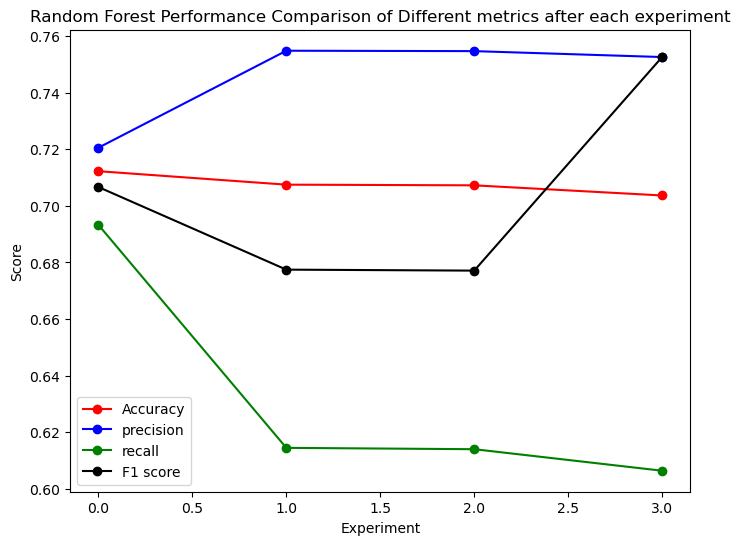

In [990]:
models = ['Accuracy', 'precision', 'recall', 'F1 score']
scores = [[accuracy_1_ran, accuracy_2_ran, accuracy_3_ran, accuracy_4_ran], [precision_1_ran, precision_2_ran, precision_3_ran, precision_4_ran], [recall_1_ran, recall_2_ran, recall_3_ran, recall_4_ran],[f1_score_1_ran, f1_score_2_ran, f1_score_3_ran, f1_score_4_ran]]
fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Random Forest Performance Comparison of Different metrics after each experiment')
plt.xlabel('Experiment')
plt.ylabel('Score')
colors = ['red', 'blue', 'green', 'black']
for i, model in enumerate(models):
    plt.plot(scores[i], marker='o', color=colors[i], label=model)
plt.legend()

#### Create a logistic regression model

In [991]:
lr_model= linear.LogisticRegression(max_iter=10000)
print(lr_model.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


Train the model using the training dataset

In [992]:
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

Get predicted class

In [993]:
pred_lr = lr_model.predict(X_test) 

The micro averaging method, which computes the F1 score globally by counting the total number of true positives, false negatives, and false positives across all classes. This method gives equal weight to each instance, regardless of its class label.

The macro averaging method, which computes the F1 score separately for each class and then takes the average over all classes. This method gives equal weight to each class, regardless of its frequency or imbalance in the dataset.

By comparing the F1 scores computed using different averaging methods, we can get a sense of how well the logistic regression model performs on the test dataset overall (micro-average) and on each individual class (macro-average). A higher F1 score indicates better performance, with a maximum score of 1.0 indicating perfect precision and recall.

In [994]:
print('F1-micro score of LR is ', metrics.f1_score(y_test, pred_lr, average='micro'))
print('F1-macro score of LR is ', metrics.f1_score(y_test, pred_lr, average='macro'))

F1-micro score of LR is  0.7061340941512125
F1-macro score of LR is  0.7032684247509473


By computing these evaluation metrics on the logistic regression model, we can assess the overall performance of the logistic regression model on the test dataset and identify areas where it may need improvement.

In [995]:
rf_clf = lr_model
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))

Accuracy 0.7061340941512125
Recall 0.6079581483830057
f1 score 0.6741079275795394
precision 0.7564102564102564


Experiment undersampling

In [996]:
X = df.drop('cardio', axis=1)
y = df['cardio']

# RandomUnderSampler
rus = RandomUnderSampler()
# undersample data
X_resampled, y_resampled = rus.fit_resample(X, y)
print(y_resampled.value_counts())

0    30383
1    30383
Name: cardio, dtype: int64


In [997]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [998]:
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))

Accuracy 0.7032913050597674
Recall 0.6452915522532708
f1 score 0.6879628035130014
precision 0.7366771159874608


Experiemnt  over sampling

In [999]:
X = df.drop('cardio', axis=1)
y = df['cardio']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())
print(X_resampled.value_counts())

0    31388
1    31388
Name: cardio, dtype: int64
id     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  BMI_State
0      50   2       168     62.0    110    80     1            1     0      0     1       0            1
66615  41   2       169     68.0    120    80     1            1     0      0     1       0            1
66618  63   2       183     96.0    120    80     1            2     0      0     0       1            1
66619  55   2       168     59.0    120    80     1            1     0      0     1       0            1
66620  50   1       156     54.0    110    70     1            2     0      0     1       0            1
                                                                                                      ..
33281  49   2       182     98.0    150    70     1            1     0      0     1       1            1
33282  54   2       160     60.0    120    80     1            1     0      0     0       0            1
33283  45  

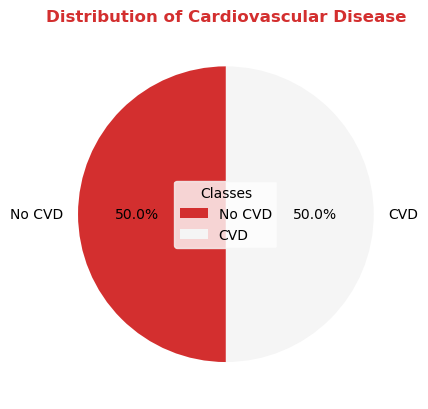

In [1000]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  
y_resampled_df = pd.DataFrame(y_resampled, columns=[y.name])  
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)
counts = df_resampled['cardio'].value_counts()
colors = ['#D32F2F', '#F5F5F5']
fig, ax = plt.subplots()
ax.pie(counts, labels=['No CVD', 'CVD'], colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_facecolor('#F5F5F5')
ax.set_title('Distribution of Cardiovascular Disease', color='#D32F2F', fontweight='bold')
ax.legend(title='Classes', loc='center', edgecolor='#F5F5F5')
plt.show()

In [1001]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [1002]:
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy1 = accuracy_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_score1 = f1_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)

Accuracy 0.6933745443017911
Recall 0.6521876981610654
f1 score 0.6801686368521122
precision 0.7106581447572983


Tune the model to improve performance

The default solver(lbfgs) in sklearn for Logistic regression does not support l1 penalty, so we only tested the default penalty (l2).

In [1003]:
X = df.drop("cardio", axis=1)
y = df["cardio"]
k = 6
# SelectKBest object with mutual_info_classif as the scoring function
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_indices = selector.get_support(indices=True)
selected_features = [X.columns[i] for i in selected_indices]
X_selected = selector.transform(X)

# Update test and training set
X_train = X_train[selected_features]
X_test = X_test[selected_features]


lr_parameters = {'C': np.logspace(-3, 3, 7)}

# Grid search
grid_search = GridSearchCV(lr_model, lr_parameters, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train with the best hyperparameters
best_lr_k = linear.LogisticRegression(max_iter=10000,**best_params)
best_lr_k.fit(X_train, y_train)

# Make predictions
y_pred = best_lr_k.predict(X_test)

# Evaluate the model
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy2 = accuracy_score(y_test, y_pred)
recall2 = recall_score(y_test, y_pred)
f1_score2 = f1_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred)


Accuracy 0.7184973846885402
Recall 0.6590044388078631
f1 score 0.7006573403000169
precision 0.7479309103994243


In [1004]:
# Define the parameter grid to search over
lr_parameters = {'C': np.logspace(-3, 3, 7)}
# Perform grid search
grid_search = GridSearchCV(estimator=lr_model, param_grid=lr_parameters, cv=5)
grid_search.fit(X_train, y_train)
print('Best parameters:', grid_search.best_params_)

Best parameters: {'C': 0.1}


In [1005]:
lr_model_tuned = grid_search.best_params_

# Train with the best hyperparameters
best_lr = linear.LogisticRegression(max_iter=10000,**best_params)
best_lr.fit(X_train, y_train)

# Make predictions
pred_tuned_lr = best_lr.predict(X_test)

print("Accuracy",  accuracy_score(y_test, pred_tuned_lr))
print("Recall",recall_score(y_test, pred_tuned_lr))
print("f1 score", f1_score(y_test, pred_tuned_lr))
print("precision",precision_score(y_test, pred_tuned_lr))
accuracy3 = accuracy_score(y_test, y_pred)
recall3 = recall_score(y_test, y_pred)
f1_score3 = f1_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred)

Accuracy 0.7184973846885402
Recall 0.6590044388078631
f1 score 0.7006573403000169
precision 0.7479309103994243


Experiment Cross validation and stratification 

In [1006]:
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# Cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(best_lr, X_train, y_train, cv=stratified_kfold, scoring=scoring_metrics)
# evaluate
print("Cross-validation results:")
accuracy4 = cv_results['test_accuracy'].mean()
recall4 = cv_results['test_recall'].mean()
precision4 = cv_results['test_precision'].mean()
f1_score4 = cv_results['test_precision'].mean()
print(accuracy4)
print(recall4)
print(precision4)
print(f1_score4)

Cross-validation results:
0.7175430190000919
0.6568306010928961
0.7474002497569526
0.7474002497569526


To choose the best threshold, we plot a receiver operating characteristic (ROC) curve and find the threshold that maximizes the area under the curve (AUC)

Optimal decision threshold: 0.4804004619526227


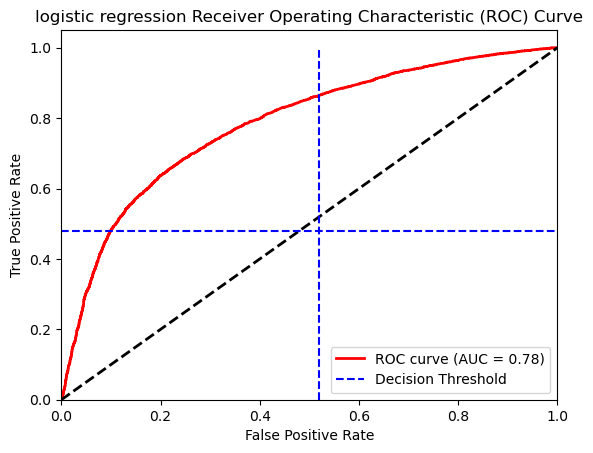

In [1007]:

y_prob = best_lr_k.predict_proba(X_test)[:, 1]
y_true = y_test

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('logistic regression Receiver Operating Characteristic (ROC) Curve')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal decision threshold:", optimal_threshold)


plt.plot([0, 1], [optimal_threshold, optimal_threshold], linestyle='--', color='blue', label='Decision Threshold')
plt.plot([1 - optimal_threshold, 1 - optimal_threshold], [0, 1], linestyle='--', color='blue')


plt.legend(loc="lower right")


plt.show()

In [1008]:
y_pred_proba =best_lr_k.predict_proba(X_test)[:, 1]  
decision_threshold = optimal_threshold
y_pred = (y_pred_proba >= decision_threshold).astype(int)  
print("Predicted probabilities of CVD:\n", y_pred_proba)
print("Predicted binary labels for CVD (0 or 1):\n", y_pred)

Predicted probabilities of CVD:
 [0.24605775 0.12654795 0.44393394 ... 0.75191253 0.40285789 0.8359281 ]
Predicted binary labels for CVD (0 or 1):
 [0 0 0 ... 1 0 1]


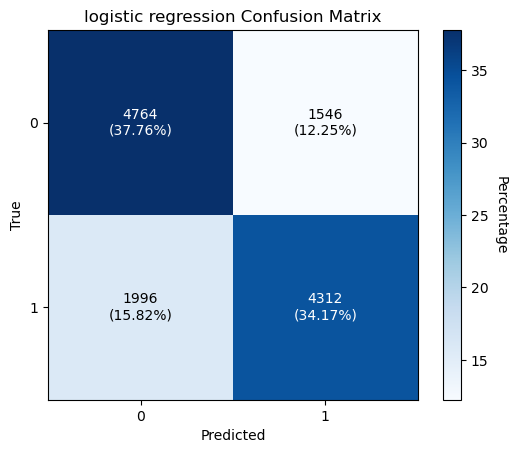

In [1009]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / np.sum(cm) * 100
fig, ax = plt.subplots()
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n({cm_percent[i, j]:.2f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
ax.set_title("logistic regression Confusion Matrix")
plt.show()


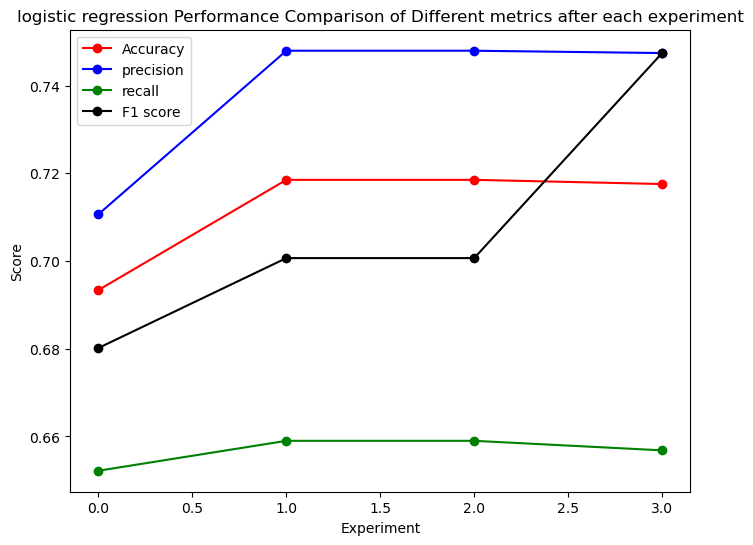

In [1010]:
models = ['Accuracy', 'precision', 'recall', 'F1 score']
scores = [[accuracy1, accuracy2, accuracy3,accuracy4], [precision1, precision2, precision3, precision4], [recall1, recall2, recall3, recall4],[f1_score1, f1_score2, f1_score3,f1_score4]]


fig, ax = plt.subplots(figsize=(8, 6))
plt.title('logistic regression Performance Comparison of Different metrics after each experiment')
plt.xlabel('Experiment')
plt.ylabel('Score')
colors = ['red', 'blue', 'green', 'black']
for i, model in enumerate(models):
    plt.plot(scores[i], marker='o', color=colors[i], label=model)
plt.legend()

Bayesian Model

# Build Naive Bayes Model with Default Hyperparameter

In [1011]:
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

#Creating a model
baye_model = GaussianNB()

Training the model using training dataset

In [1012]:
baye_model.fit(X_train, y_train)

GaussianNB()

Get predicted class

In [1013]:
bay_pred = baye_model.predict(X_test)

Overall performance on the test dataset Discovering areas of improvement.

In [1014]:
print('Accuracy score for training dataset:', accuracy_score(y_test, bay_pred))
print('Precision score for training dataset:', precision_score(y_test, bay_pred))
print('Recall score for training dataset:', recall_score(y_test, bay_pred))
print('F1 score for training dataset:', f1_score(y_test, bay_pred))

Accuracy score for training dataset: 0.7132667617689016
Precision score for training dataset: 0.7664421553090333
Recall score for training dataset: 0.6133481293595434
F1 score for training dataset: 0.6814019020781965


Experimenting undersampling

In [1015]:
x = df.drop('cardio', axis = 1)
y = df['cardio']

#RandomUnderSampler
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X,y)
print(y_resampled.value_counts())

0    30383
1    30383
Name: cardio, dtype: int64


In [1016]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [1017]:
baye_model = GaussianNB()
baye_model.fit(X_train, y_train)
bay_pred = baye_model.predict(X_test)
print('Accuracy score for training dataset:', accuracy_score(y_test, bay_pred))
print('Precision score for training dataset:', precision_score(y_test, bay_pred))
print('Recall score for training dataset:', recall_score(y_test, bay_pred))
print('F1 score for training dataset:', f1_score(y_test, bay_pred))

Accuracy score for training dataset: 0.7043556574422793
Precision score for training dataset: 0.7774193548387097
Recall score for training dataset: 0.5839121305120336
F1 score for training dataset: 0.6669126464348307


Experiment oversampling

In [1018]:
X = df.drop('cardio', axis=1)
y = df['cardio']
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)
print(y_resampled.value_counts())
print(X_resampled.value_counts())

0    31388
1    31388
Name: cardio, dtype: int64
id     age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  BMI_State
13768  49   1       165     77.0    120    80     1            1     0      0     1       1            2
0      50   2       168     62.0    110    80     1            1     0      0     1       0            1
66672  57   2       168     57.0    110    70     1            1     0      0     1       0            1
66654  53   1       160     80.0    140    90     1            1     0      0     1       1            1
66655  48   2       171     66.0    100    80     1            1     1      0     1       0            1
                                                                                                      ..
33291  48   1       158     75.0    140    90     1            3     1      0     0       1            1
33292  51   1       168     80.0    110    80     1            1     0      0     1       1            1
33293  57  

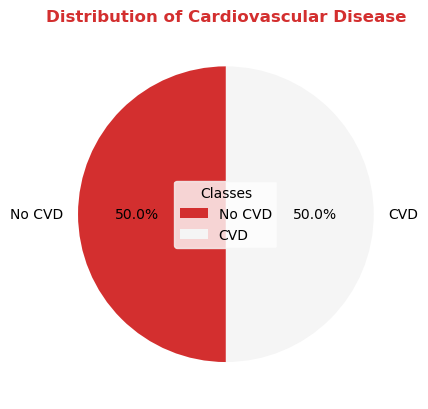

In [1019]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)  
y_resampled_df = pd.DataFrame(y_resampled, columns=[y.name])  
df_resampled = pd.concat([X_resampled_df, y_resampled_df], axis=1)
counts = df_resampled['cardio'].value_counts()
colors = ['#D32F2F', '#F5F5F5']
fig, ax = plt.subplots()
ax.pie(counts, labels=['No CVD', 'CVD'], colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_facecolor('#F5F5F5')
ax.set_title('Distribution of Cardiovascular Disease', color='#D32F2F', fontweight='bold')
ax.legend(title='Classes', loc='center', edgecolor='#F5F5F5')
plt.show()

In [1020]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)
X_test, X_predict, y_test, y_predict = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [1021]:
baye_model = GaussianNB()
baye_model.fit(X_train, y_train)
bay_pred = baye_model.predict(X_test)
print('Accuracy score for training dataset:', accuracy_score(y_test, bay_pred))
print('Precision score for training dataset:', precision_score(y_test, bay_pred))
print('Recall score for training dataset:', recall_score(y_test, bay_pred))
print('F1 score for training dataset:', f1_score(y_test, bay_pred))
accuracy1 = accuracy_score(y_test, y_pred)
recall1 = recall_score(y_test, y_pred)
f1_score1 = f1_score(y_test, y_pred)
precision1 = precision_score(y_test, y_pred)

Accuracy score for training dataset: 0.7114439689332699
Precision score for training dataset: 0.7795011527981556
Recall score for training dataset: 0.589568801521877
F1 score for training dataset: 0.671360231067786


Experiment Feature Selection

In [1022]:
X = df.drop("cardio", axis=1)
y = df["cardio"]
k = 6
# SelectKBest object with mutual_info_classif as the scoring function
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_indices = selector.get_support(indices=True)
selected_features = [X.columns[i] for i in selected_indices]
X_selected = selector.transform(X)
print("Selected features:", selected_features)

Selected features: ['age', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'BMI_State']


In [1023]:
# Update test and training set
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [1024]:
parameters = {'max_depth': range(1, 11),
              'min_samples_leaf': range(1, 6)}

baye_gridsearch = GridSearchCV(estimator=baye_model, param_grid=parameters, cv=5, n_jobs=-1)
param_grid_gnb = {'var_smoothing': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]}

In [1025]:
# Grid search
gaussianNB_cv = GridSearchCV(baye_model, param_grid_gnb, scoring='f1', cv=10, verbose=1, n_jobs=-1)
gaussianNB_cv.fit(X_train, y_train)
best_param = gaussianNB_cv.best_params_

Fitting 10 folds for each of 6 candidates, totalling 60 fits


In [1026]:
if 'C' in best_params:
    del best_params['C']

best_nb_k = GaussianNB(**best_params)

In [1027]:
best_nb_k.fit(X_train, y_train)
#Train the test
y_pred = best_nb_k.predict(X_test)

In [1028]:
# Evaluate the model
print("Accuracy",  accuracy_score(y_test, y_pred))
print("Recall",recall_score(y_test, y_pred))
print("f1 score", f1_score(y_test, y_pred))
print("precision",precision_score(y_test, y_pred))
accuracy2 = accuracy_score(y_test, y_pred)
recall2 = recall_score(y_test, y_pred)
f1_score2 = f1_score(y_test, y_pred)
precision2 = precision_score(y_test, y_pred)

Accuracy 0.7142177841179268
Recall 0.6152504755865568
f1 score 0.6827938071780436
precision 0.76699604743083


In [1029]:
# Define the parameter grid to search over
parameters = {'max_depth': range(1, 11),
              'min_samples_leaf': range(1, 6)}

baye_gridsearch = GridSearchCV(estimator=baye_model, param_grid=parameters, cv=5, n_jobs=-1)
param_grid_gnb = {'var_smoothing': [0.000000001, 0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001]}
# Perform grid search
gaussianNB_cv = GridSearchCV(baye_model, param_grid_gnb, scoring='f1', cv=3, verbose=1, n_jobs=-1)
gaussianNB_cv.fit(X_train, y_train)

print('Best parameters:', gaussianNB_cv.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'var_smoothing': 0.0001}


In [1030]:
baye_tuned = gaussianNB_cv.best_params_

# Train with the best hyperparameters
best_nb_k = GaussianNB(**best_params)
best_nb_k.fit(X_train, y_train)
# Make predictions
pred_tuned_lr = best_nb_k.predict(X_test)

print("Accuracy",  accuracy_score(y_test, pred_tuned_lr))
print("Recall",recall_score(y_test, pred_tuned_lr))
print("f1 score", f1_score(y_test, pred_tuned_lr))
print("precision",precision_score(y_test, pred_tuned_lr))
accuracy3 = accuracy_score(y_test, y_pred)
recall3 = recall_score(y_test, y_pred)
f1_score3 = f1_score(y_test, y_pred)
precision3 = precision_score(y_test, y_pred)

Accuracy 0.7142177841179268
Recall 0.6152504755865568
f1 score 0.6827938071780436
precision 0.76699604743083


Experimental Cross Validation and Stratification

In [1038]:
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
# Cross-validation
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
cv_results = cross_validate(best_nb_k, X_train, y_train, cv=stratified_kfold, scoring=scoring_metrics)
# evaluate
print("Cross-validation results:")
accuracy4 = cv_results['test_accuracy'].mean()
recall4 = cv_results['test_recall'].mean()
precision4 = cv_results['test_precision'].mean()
f1_score4 = cv_results['test_precision'].mean()
print(accuracy4)
print(recall4)
print(precision4)
print(f1_score4)

Cross-validation results:
0.7102609408572484
0.6142987249544627
0.7599452451026435
0.7599452451026435


Optimal decision threshold: 0.3785014696131972


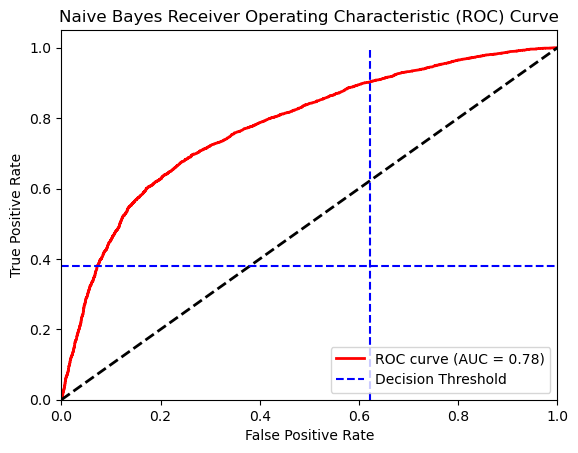

In [1039]:
y_prob = best_nb_k.predict_proba(X_test)[:, 1]
y_true = y_test

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Naive Bayes Receiver Operating Characteristic (ROC) Curve')

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal decision threshold:", optimal_threshold)


plt.plot([0, 1], [optimal_threshold, optimal_threshold], linestyle='--', color='blue', label='Decision Threshold')
plt.plot([1 - optimal_threshold, 1 - optimal_threshold], [0, 1], linestyle='--', color='blue')


plt.legend(loc="lower right")


plt.show()

In [1040]:
y_pred_proba =best_nb_k.predict_proba(X_test)[:, 1]  
decision_threshold = optimal_threshold
y_pred = (y_pred_proba >= decision_threshold).astype(int)  
print("Predicted probabilities of CVD:\n", y_pred_proba)
print("Predicted binary labels for CVD (0 or 1):\n", y_pred)

Predicted probabilities of CVD:
 [0.23953319 0.02549425 0.16122949 ... 0.7543606  0.25568023 0.99151359]
Predicted binary labels for CVD (0 or 1):
 [0 0 0 ... 1 0 1]


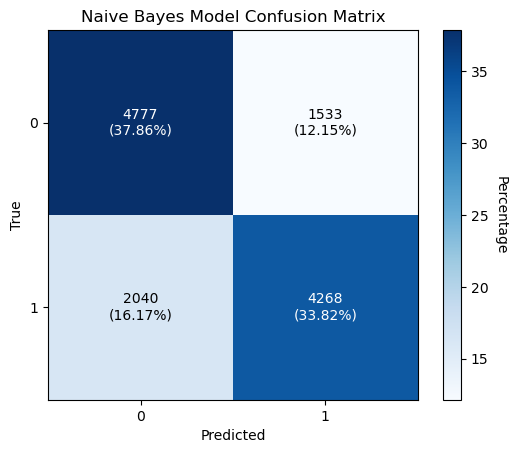

In [1041]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / np.sum(cm) * 100
fig, ax = plt.subplots()
im = ax.imshow(cm_percent, interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Percentage', rotation=-90, va="bottom")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]}\n({cm_percent[i, j]:.2f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
ax.set_title("Naive Bayes Model Confusion Matrix")
plt.show()

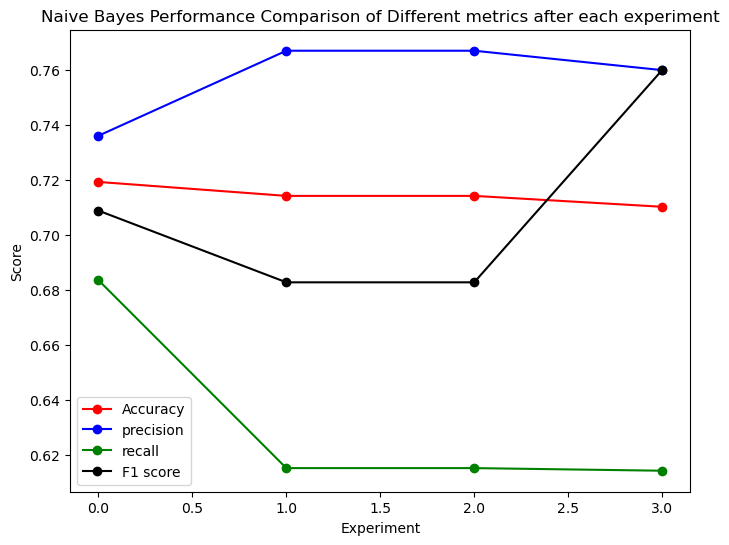

In [1042]:
models = ['Accuracy', 'precision', 'recall', 'F1 score']
scores = [[accuracy1, accuracy2, accuracy3,accuracy4], [precision1, precision2, precision3,precision4], [recall1, recall2, recall3,recall4],[f1_score1, f1_score2, f1_score3,f1_score4]]


fig, ax = plt.subplots(figsize=(8, 6))
plt.title('Naive Bayes Performance Comparison of Different metrics after each experiment')
plt.xlabel('Experiment')
plt.ylabel('Score')
colors = ['red', 'blue', 'green', 'black']
for i, model in enumerate(models):
    plt.plot(scores[i], marker='o', color=colors[i], label=model)
plt.legend()